In [1]:
import geemap

In [2]:
Map = geemap.Map()
Map

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=yaGcQXQyjnr5b9w08SaaS9fjXmp2sYkNz_2qOKIcwTQ&tc=xy34Djwx0YzL8XifJZK__e-THhklm01a5_SzUh2gv4k&cc=ow7_O5UmxRsYI-Ha61kwpc_o-z3nIfYpFI4veg6J4to

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeaYSHCrcIX_O1re_5i97s6kzYJyarN2miXEFy038uoB6wdxtydLCipJls4

Successfully saved authorization token.


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [3]:
# Import the necesarry libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geemap as emap
from datetime import datetime
import ee

# Trigger GEE
ee.Authenticate()
ee.Initialize()

In [4]:
# Area of interest, somewhere near Berlin, Germany
roi = ee.Geometry.Rectangle([13.7828066313537398, 52.3817774379818601,
                            13.8154296884080576, 52.4099122039370400])
start_date = '2014-01-01'
end_date = '2021-12-31'

# Always better to filter the dataset as finer as possible
collectionS1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filterMetadata('resolution_meters', 'equals', 10)\
    .filterBounds(roi).filterDate(start_date, end_date)


# Filter for ascending orbit images
filtered_collection_2014_2021 = collectionS1.filterMetadata('orbitProperties_pass', 'equals', 'ASCENDING')
# Sort the filtered collection by date in ascending order
sorted_collection_2014_2021 = filtered_collection_2014_2021.sort('system:time_start')

# create interactive map for visual representations
Map = emap.Map()
# Add the ROI to the map
Map.addLayer(sorted_collection_2014_2021.first().select('VV'), {'min': -25, 'max': 5}, 'Collection First Image')
Map.addLayer(roi, {}, 'ROI Bounding Box')
Map.addLayerControl()
# Center the map on the ROI
Map.centerObject(roi, 12)  # You can adjust the zoom level (12 in this case)
Map

Map(center=[52.39584444865192, 13.79911815987345], controls=(WidgetControl(options=['position', 'transparent_b…

Processed Images: 380
Starting time: 20240325034338
Ending time: 20240325034345
Elapsed time:0:00:06.945736 Hours


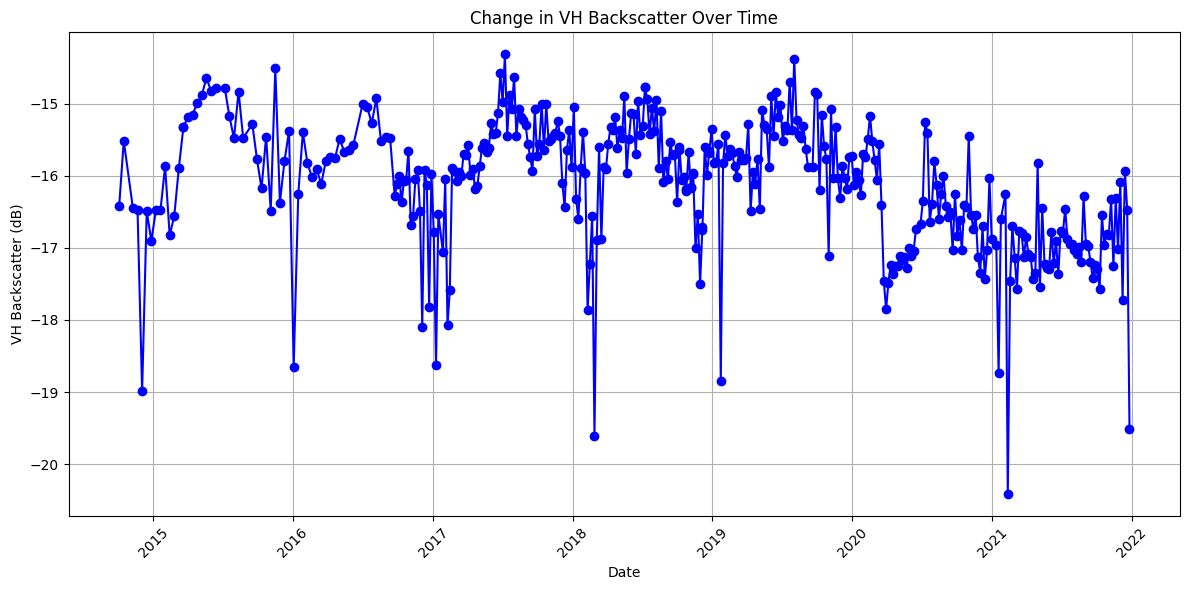

In [5]:
time_start = datetime.now()

def datedist(img):
 img = ee.Image(img)
 date = img.get('system:time_start')

 vh_band = img.select('VH')
 stats = vh_band.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=10)
 backscatter_value = stats.get('VH')
 return img.set('DateDist', date).set('backscatter', backscatter_value)

# Map the function to the image collection
sorted_collection_2014_2021_changed = sorted_collection_2014_2021.map(datedist)

# Use aggregate_array to get the 'DateDist' values as an array
dates_array = sorted_collection_2014_2021_changed.aggregate_array('DateDist')

# Use aggregate_array to get the 'DateDist' values as an array
backscatter_array = sorted_collection_2014_2021_changed.aggregate_array('backscatter')

# Convert the array to a list using getInfo()
dates_list = dates_array.getInfo()
backscatter_list = backscatter_array.getInfo()
string_timestamps = [datetime.utcfromtimestamp(int(date_str) // 1000) for date_str in dates_list]

# Create a DataFrame to store the data
data = {'Date': string_timestamps, 'VH Backscatter': backscatter_list}
df = pd.DataFrame(data)

# Plot the VH backscatter values over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['VH Backscatter'], marker='o', linestyle='-', color='b')
plt.title('Change in VH Backscatter Over Time')
plt.xlabel('Date')
plt.ylabel('VH Backscatter (dB)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

time_end = datetime.now()
print(f'Processed Images: {sorted_collection_2014_2021.size().getInfo()}')
print(f'Starting time: {time_start.strftime("%Y%m%d%H%M%S")}')
print(f'Ending time: {time_end.strftime("%Y%m%d%H%M%S")}')
print(f'Elapsed time:{time_end- time_start} Hours')
plt.show()

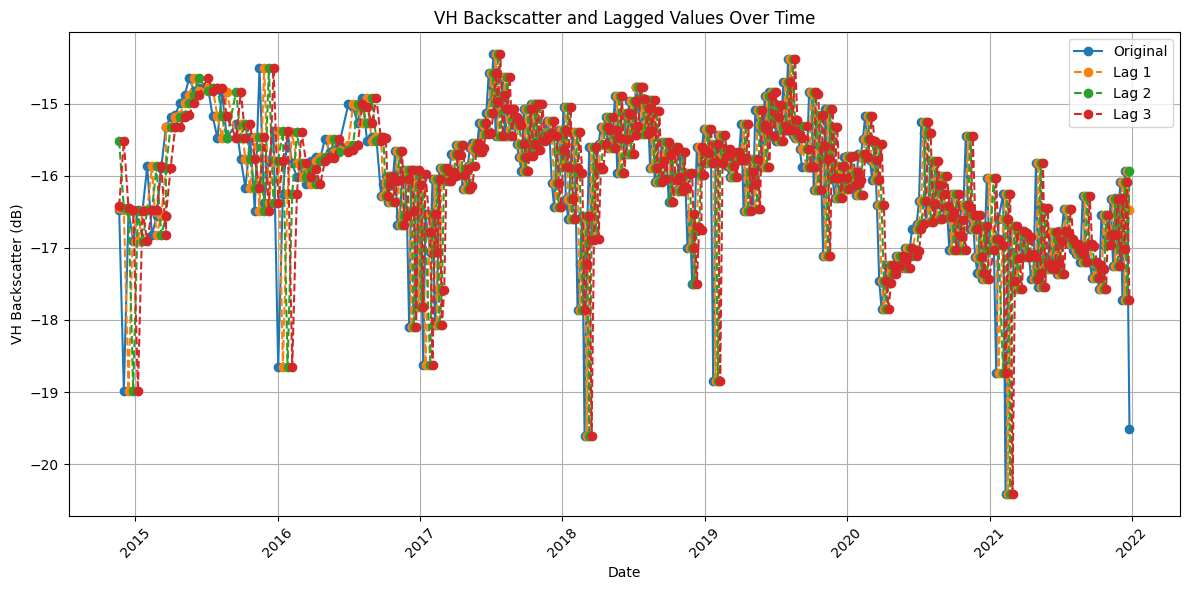

In [8]:
# Plot both original VH backscatter values and lagged values
plt.figure(figsize=(12, 6))

# Plot original VH backscatter values
plt.plot(df['Date'], df['VH Backscatter'], label='Original', marker='o')

# Plot lagged VH backscatter values
for lag in range(1, lags + 1):
    plt.plot(df['Date'], df[f'VH Backscatter Lag {lag}'], label=f'Lag {lag}', linestyle='--', marker='o')

plt.title('VH Backscatter and Lagged Values Over Time')
plt.xlabel('Date')
plt.ylabel('VH Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the lagged time steps
lags = 3  # Adjust this number as needed

# Shift the backscatter values to create lagged features
for lag in range(1, lags + 1):
    df[f'VH Backscatter Lag {lag}'] = df['VH Backscatter'].shift(lag)

# Drop rows with NaN values resulting from shifting
df.dropna(inplace=True)

# Split the data into training and testing sets
X = df.drop(columns=['Date', 'VH Backscatter'])
y = df['VH Backscatter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the time series model (Random Forest Regressor in this case)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict VH backscatter values on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 0.45718625221399967


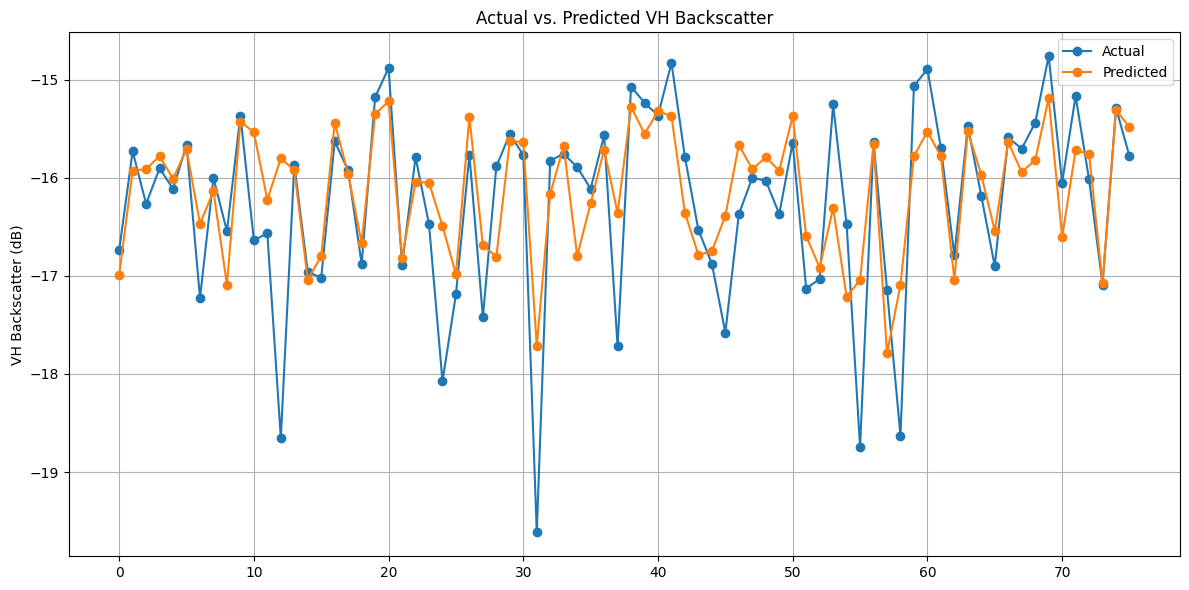

In [9]:
# Optionally, you can plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
# Plot actual values
plt.plot(range(len(y_test)), y_test, label='Actual', marker='o')
# Plot predicted values
plt.plot(range(len(y_test)), y_pred, label='Predicted', marker='o')

plt.title('Actual vs. Predicted VH Backscatter')
plt.ylabel('VH Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
